# Preprocessing and data set creation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
import os
import tensorflow as tf
import tensorflow_datasets as tfds
from astropy.io import fits
from TNGDataSet import TNGDataSet
plt.style.use(astropy_mpl_style)
import jax
import jax.numpy as jnp

In [ ]:
# Dummy scaling function
def ScaleImage(img):
    return img[0:500,0:500].astype('float32')

## Tracing function
set to 0 for no traces up to 4 for alot of traces

In [ ]:
os.environ["DIFF_TRACE"]="0"

## Set up dataset creation arguments and load the data set

Dataset is only loaded the first time and will be stored locally in data_dir/tng_data_set folder
If you wish to reload you need to delete this folder and relanch this cell

In [ ]:
arg_dict = {
    'train_percent':0.00001,
    'val_percent':0.00001, 
    'test_percent':0.00001 , 
    'generation_verbosity' : 10 , 
    'Scaler_fcn':ScaleImage,
    'band_filters' : ['CFHT_MEGACAM.U', 'SUBARU_HSC.G' ,'SUBARU_HSC.R' ,'CFHT_MEGACAM.R' ,'SUBARU_HSC.I', 'SUBARU_HSC.Z' ,'SUBARU_HSC.Y']
    }
#subsets = [tfds.Split.TRAIN,tfds.Split.VALIDATION, tfds.Split.TEST]
subsets = [tfds.Split.TRAIN,tfds.Split.VALIDATION]
ds = tfds.load('TNGDataSet', split=subsets, data_dir="/scratch/astroinfo2023/diffusion/", builder_kwargs=arg_dict)

To recover the subsets you can recover them directly from the newly created dataset

In [ ]:
train_dataset, validation_dataset = ds

In [ ]:
train_dataset

In [ ]:
# Training set preparation
def load_dataset(batch_size, noise_dist_std):

  def pre_process(im):
    """ Pre-processing function preparing data for denoising task
    """
    # Cutout a portion of the map
    x = tf.image.resize_with_crop_or_pad(im['img'][..., tf.newaxis], 128, 128)
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)
    # Sample random Gaussian noise
    u = tf.random.normal(tf.shape(x))
    # Sample standard deviation of noise corruption
    s = noise_dist_std * tf.random.normal((1, 1, 1))
    # Create noisy image
    y = x + s * u
    return {'x':x, 'y':y, 'u':u,'s':s}

  ds = train_dataset
  ds = ds.shuffle(buffer_size=10*batch_size)
  ds = ds.repeat()
  ds = ds.map(pre_process)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
  return ds.as_numpy_iterator()

In [28]:
cosmos_dset = load_dataset(32, 25)
batch = next(cosmos_dset)

2023-07-05 19:03:32.420793: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2023-07-05 19:03:32.421736: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


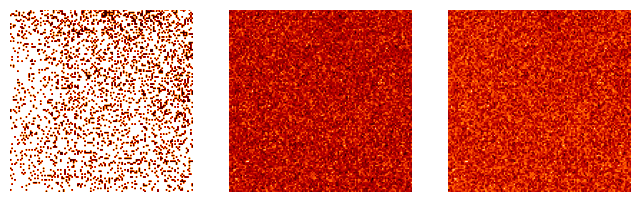

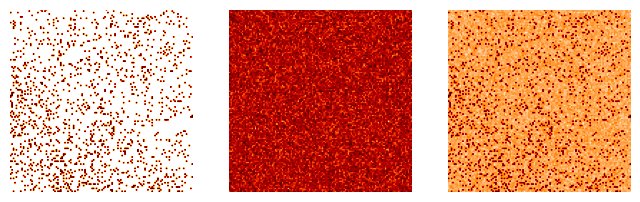

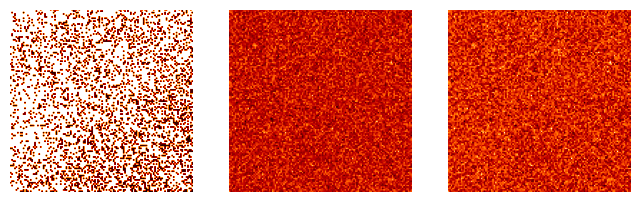

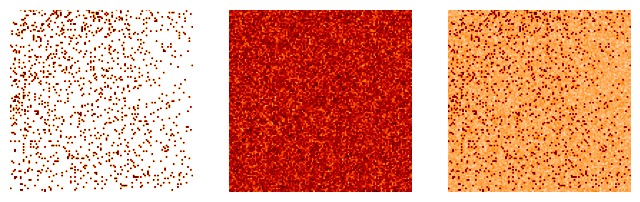

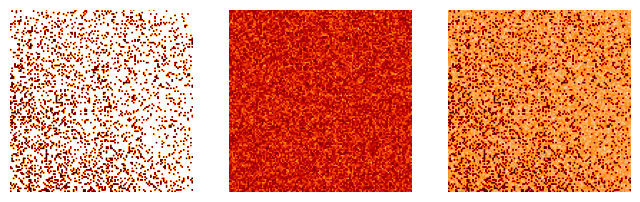

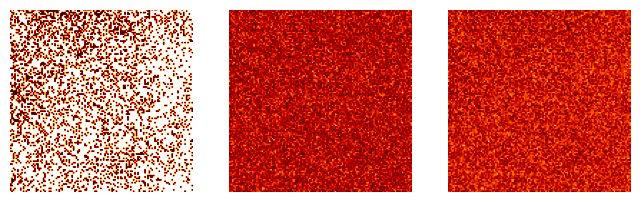

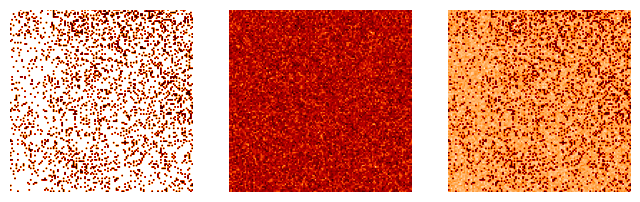

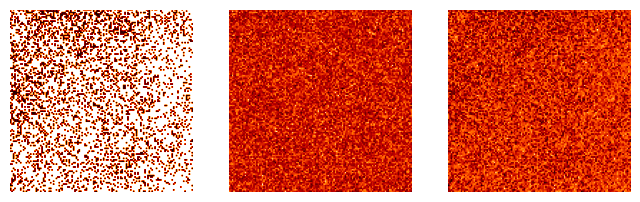

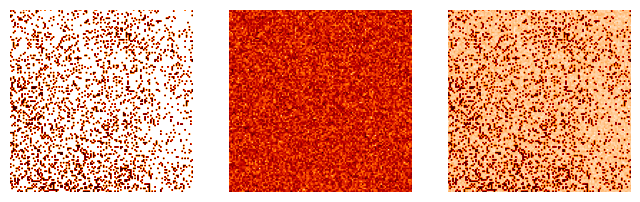

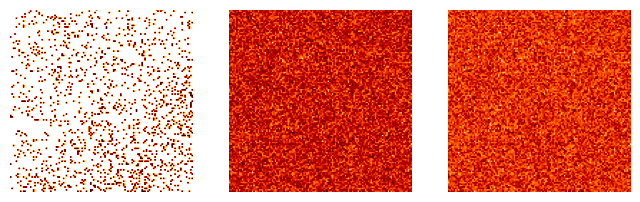

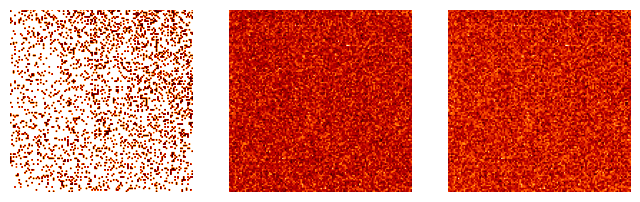

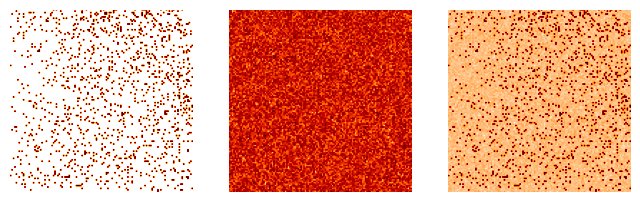

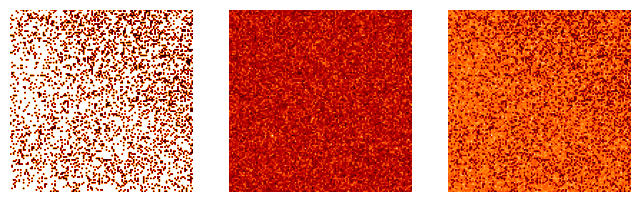

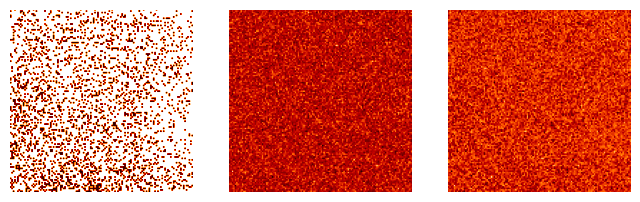

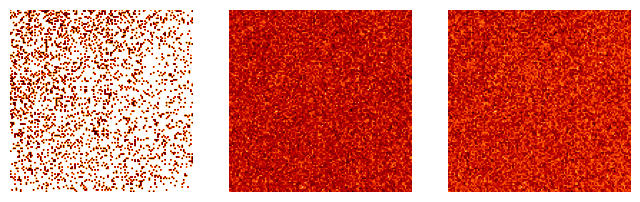

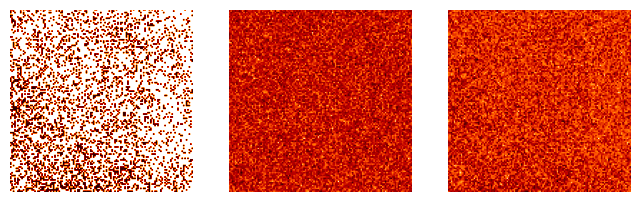

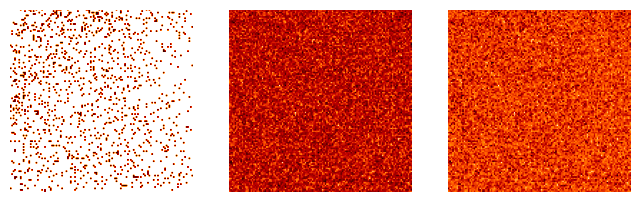

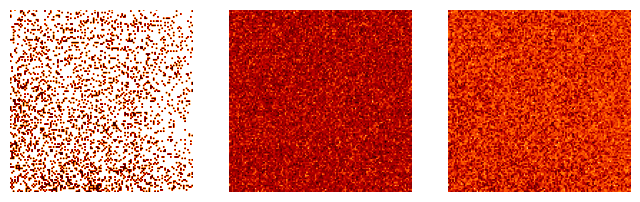

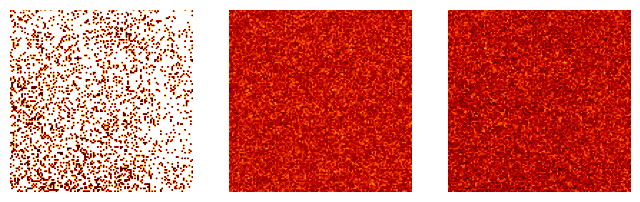

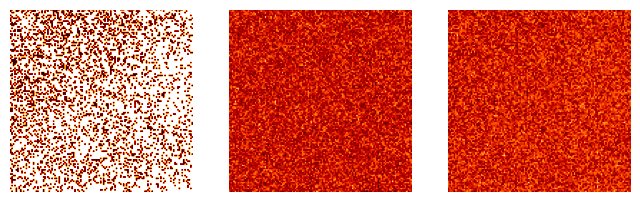

In [29]:
%pylab inline
for i in range(20):
    figure()
    subplot(131)
    imshow(batch['x'][i])
    axis('off')
    subplot(132)
    imshow(batch['u'][i])
    axis('off')
    subplot(133)
    imshow(batch['y'][i])
    axis('off')


In [10]:
## np.shape(batch['x'])

In [11]:
np.shape(batch['y'][i])

(128, 128, 1)

In [12]:
# Ok, so now we just need to train 
from models import SmallUResNet
from normalization import SNParamsTree
import haiku as hk
import optax

In [13]:
model = hk.transform_with_state(lambda x, sigma, is_training=False: SmallUResNet()(x, sigma, is_training))

In [14]:
params, state = model.init(jax.random.PRNGKey(0), jnp.zeros([1,128,128,1]), jnp.zeros([1,1,1,1]), is_training=True)

In [15]:
def lr_schedule(step):
  """Linear scaling rule optimized for 90 epochs."""
  steps_per_epoch = 40000 // 32

  current_epoch = step / steps_per_epoch  # type: float
  lr = (1.0 * 32) / 32
  boundaries = jnp.array((20, 40, 60)) * steps_per_epoch
  values = jnp.array([1., 0.1, 0.01, 0.001]) * lr

  index = jnp.sum(boundaries < step)
  return jnp.take(values, index)

In [16]:
optimizer = optax.chain(
  optax.adam(learning_rate=1e-3),
  optax.scale_by_schedule(lr_schedule)
)
rng_seq = hk.PRNGSequence(42)

In [17]:
sn_fn = hk.transform_with_state(lambda x: SNParamsTree(ignore_regex='[^?!.]*b', val=1.)(x))

In [18]:
_, sn_state = sn_fn.init(next(rng_seq), params)

In [19]:
params, sn_state = sn_fn.apply(None, sn_state, None, params)

In [20]:
opt_state = optimizer.init(params)

In [21]:
def loss_fn(params, state, rng_key, batch):
    score, state = model.apply(params, state, rng_key, batch['y'], batch['s'], is_training=True)
    loss = jnp.mean((batch['u'] + batch['s'] * (score))**2)
    return loss, state

In [22]:
@jax.jit
def update(params, state, sn_state, rng_key, opt_state, batch):
    (loss, state), grads = jax.value_and_grad(loss_fn, has_aux=True)(params, state, rng_key, batch)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    new_params, new_sn_state = sn_fn.apply(None, sn_state, None, new_params)
    return loss, new_params, state, new_sn_state, new_opt_state

In [23]:
from flax.metrics import tensorboard
import pickle

In [24]:
summary_writer = tensorboard.SummaryWriter('models/score_model_0.025')

In [25]:
for step in range(10000):
    print(step)
    loss, params, state, sn_state, opt_state = update(params, state, sn_state,
                                                      next(rng_seq), opt_state,
                                                      next(cosmos_dset))
    summary_writer.scalar('train_loss', loss, step)
    summary_writer.scalar('learning_rate', lr_schedule(step)*1e-3, step)
    
    if step%5000 ==0:
        with open('models/score_model_0.025/model-%d.pckl'%step, 'wb') as file:
            pickle.dump([params, state, sn_state], file)

0
1
2
3
4


KeyboardInterrupt: 

In [ ]:
def score_fn(y, s):
    score, _ = model.apply(params, state, None, y, s.reshape((-1,1,1,1)), is_training=False)
    return score

In [ ]:
score = score_fn(batch['y'], batch['s'])
     

In [ ]:
for i in range(16):
    figure(figsize=[20,5])
    subplot(141)
    imshow(batch['x'][i])
    axis('off')
    subplot(142)
    imshow(batch['y'][i])
    axis('off')
    subplot(143)
    imshow(score[i])
    axis('off')
    subplot(144)
    imshow(batch['y'][i] + (batch['s']**2 * score)[i])
    axis('off')